<img src='images/pic1.jpg'/>

# Stack Overflow: Tag Prediction

In [0]:
!pip3 install scikit-multilearn

     |████████████████████████████████| 92kB 5.0MB/s 


In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive



<h3>  Cleaning and preprocessing of Questions </h3>

<h3> Preprocessing </h3>

<ol> 
    <li> Sample 0.5M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
</ol>

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [0]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

<h1> Machine Learning Models </h1>

<h2>  Modeling with less data points (0.5M data points) and more weight to title and 500 tags only. </h2>

In [0]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [0]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


In [0]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 424
Percent of questions containing code: 57
Time taken to run this cell : 0:23:12.329039


In [0]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

__ Saving Preprocessed data to a Database __

## Taking only 100k data points.

In [0]:
#0.5 Million entries are in the db out of which we take only 100k entries to dataframe.
write_db = 'gdrive/My Drive/data/Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed LIMIT 100000""", conn_r)
conn_r.commit()
conn_r.close()

In [0]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [0]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 100000
number of dimensions : 2


<h2>  Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

__ We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [0]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

__ Converting string Tags to multilable output variables __ 

In [0]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ Selecting 500 Tags __

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

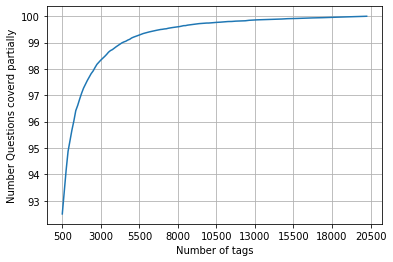

with  5500 tags we are covering  99.481 % of questions
with  500 tags we are covering  92.5 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [0]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 7500 out of  100000


In [0]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [0]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (80000, 500)
Number of data points in test data : (20000, 500)


<h2> Featurizing data </h2>

<h3> Featurizing data with Count vectorizer(BOW) upto 4Grams </h3>

In [0]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=100000,tokenizer = lambda x: x.split() , ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:33.147802


In [0]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (80000, 100000) Y : (80000, 500)
Dimensions of test data X: (20000, 100000) Y: (20000, 500)


<h3> Applying Logistic Regression with OneVsRest Classifier </h3>

In [0]:
from sklearn.model_selection import cross_val_score

cv_scores = []
alpha = [10**-5,10**-3,10**-1,10**0,10**1,10**3]
for i in alpha:
  classifier = OneVsRestClassifier(SGDClassifier(loss='log',alpha = i, penalty='l1'))
  scores = cross_val_score(classifier, x_train_multilabel, y_train, cv=3, scoring='f1_micro')
  cv_scores.append(scores.mean())

f_score = [x for x in cv_scores]
# determining best alpha
optimal_alpha = alpha[f_score.index(max(f_score))]
print('\nThe optimal value of alpha is :', optimal_alpha)


The optimal value of alpha is : 0.001


In [0]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.13485
Hamming loss  0.0036648
Micro-average quality numbers
Precision: 0.5203, Recall: 0.2821, F1-measure: 0.3658
Macro-average quality numbers
Precision: 0.3418, Recall: 0.2176, F1-measure: 0.2409
              precision    recall  f1-score   support

           0       0.72      0.29      0.41       820
           1       0.41      0.13      0.19      1931
           2       0.41      0.12      0.19       544
           3       0.44      0.27      0.34       222
           4       0.80      0.41      0.55      1311
           5       0.68      0.56      0.61      1014
           6       0.68      0.41      0.51      1374
           7       0.74      0.60      0.66       702
           8       0.80      0.58      0.67      1424
           9       0.70      0.19      0.29      1037
          10       0.70      0.40      0.51       797
          11       0.53      0.42      0.47       156
          12       0.49      0.47      0.48        36
          13       0.74      0.4

<h3> Applying Linear SVM with OneVsRest Classifier </h3>

In [0]:
start = datetime.now()
from sklearn.model_selection import cross_val_score

cv_scores = []
alpha = [10**-5,10**-3,10**-1,10**1,10**3]
for i in alpha:
  classifier = OneVsRestClassifier(SGDClassifier(loss='hinge',alpha = i, penalty='l1'))
  scores = cross_val_score(classifier, x_train_multilabel, y_train, cv=3, scoring='f1_micro')
  print("for alpha :", alpha ,"f1 score is :" ,scores.mean())
  cv_scores.append(scores.mean())

f_score = [x for x in cv_scores]
# determining best alpha
optimal_alpha = alpha[f_score.index(max(f_score))]
print('\nThe optimal value of alpha is :', optimal_alpha)
print("Time taken to run this cell :", datetime.now() - start)

for alpha : [1e-05, 0.001, 0.1, 10, 1000] f1 score is : 0.28895533647313343
for alpha : [1e-05, 0.001, 0.1, 10, 1000] f1 score is : 0.3803564728946876
for alpha : [1e-05, 0.001, 0.1, 10, 1000] f1 score is : 0.017655385937113577
for alpha : [1e-05, 0.001, 0.1, 10, 1000] f1 score is : 0.0
for alpha : [1e-05, 0.001, 0.1, 10, 1000] f1 score is : 0.0039678177991261596

The optimal value of alpha is : 0.001
Time taken to run this cell : 2:18:13.812353


 In the above cell there is a typing mistake, editing and running it againa takes a lot of time so iam correcting here.
 - for alpha : 1e-05, f1 score is : 0.28895533647313343
 - for alpha :  0.001, f1 score is : 0.3803564728946876
 - for alpha :  0.1,  f1 score is : 0.017655385937113577
 - for alpha :  10,  f1 score is : 0.0
 - for alpha :  1000,  f1 score is : 0.0039678177991261596


In [0]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.001, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.13425
Hamming loss  0.0036292
Micro-average quality numbers
Precision: 0.5313, Recall: 0.2676, F1-measure: 0.3560
Macro-average quality numbers
Precision: 0.2835, Recall: 0.2098, F1-measure: 0.2196
              precision    recall  f1-score   support

           0       0.61      0.33      0.43       820
           1       0.27      0.04      0.07      1931
           2       0.44      0.15      0.23       544
           3       0.43      0.28      0.34       222
           4       0.83      0.40      0.54      1311
           5       0.75      0.53      0.62      1014
           6       0.69      0.41      0.51      1374
           7       0.80      0.58      0.67       702
           8       0.91      0.55      0.68      1424
           9       0.66      0.29      0.40      1037
          10       0.73      0.40      0.52       797
          11       0.57      0.31      0.40       156
          12       0.35      0.47      0.40        36
          13       0.77      0.4

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Micro f-score", "Hamming loss", "Precision" , "Recall"]

x.add_row(["Linear Regression",0.3658, 0.0036648 ,0.5203 ,0.2821])
x.add_row(["Linear SVM ",0.3560, 0.0036292 , 0.5313 , 0.2676])

In [3]:
print(x)

+-------------------+---------------+--------------+-----------+--------+
|       Model       | Micro f-score | Hamming loss | Precision | Recall |
+-------------------+---------------+--------------+-----------+--------+
| Linear Regression |     0.3658    |  0.0036648   |   0.5203  | 0.2821 |
|    Linear SVM     |     0.356     |  0.0036292   |   0.5313  | 0.2676 |
+-------------------+---------------+--------------+-----------+--------+


## Conclusions:

- A multilabel classification problem is solved with some simple machine learning models like logistic and linear SVM by One VS Rest classifier.
- As the data is very huge with so many tags, therefore due to memory constraints we took only 100k data points and 500 tags .
- Feature engineering is done on the body of the question by preprocessing it with BOW 2 grams.
- **More weightage is given to the title(3times) of the question as it is more powerful in predicting the tag.**
- Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm. Along with that hamming loss is also considered.
- Multilearn libraries , Decision trees or Random forests can also be implemented but it takes much more time to compute. So we limited ourselves to LR AND Linear SVM.
- **The results are plotted in a table above and the f1-score is not very high as we took only a small part of the data 100k out of 6M data points. And also Accuracy is very low as it is not the correct measure for this problem.**  